# Config

In [3]:
"""
This notebook estimates the distribution of AI chips (H100-equivalents and TPUs)
across major tech companies based on NVIDIA revenue data and other information.

"""

# Install required packages
!pip install squigglepy


[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [4]:
# Squigglepy documentation: https://github.com/rethinkpriorities/squigglepy
import squigglepy as sq
import numpy as np
import matplotlib.pyplot as plt
from squigglepy.numbers import K, M, B
from pprint import pprint
import pandas as pd

sq.set_seed(42)
np.random.seed(42)

In [5]:
# Helper Functions
# ================

from scipy import stats

# alternative to squigglepy
def generate_lognormal_from_percentiles(x_lower, x_upper, p_lower, p_upper, n=10000):
    """
    Generate lognormal distribution samples from percentile constraints.

    Args:
        x_lower: Lower bound value at p_lower percentile
        x_upper: Upper bound value at p_upper percentile
        p_lower: Lower percentile (e.g., 20 for 20th percentile)
        p_upper: Upper percentile (e.g., 80 for 80th percentile)
        n: Number of samples to generate

    Returns:
        numpy array of lognormal samples
    """
    z_lower = stats.norm.ppf(p_lower / 100)
    z_upper = stats.norm.ppf(p_upper / 100)

    mu = (np.log(x_lower) * z_upper - np.log(x_upper) * z_lower) / (z_upper - z_lower)
    sigma = (np.log(x_upper) - np.log(x_lower)) / (z_upper - z_lower)

    return np.random.lognormal(mean=mu, sigma=sigma, size=n)

# wrapper for sq.to, with default credibility of 80% (library default is 90)
def sq_distribution(x_lower, x_upper, credibility=80, lclip = None, rclip = None):
    return sq.to(x_lower, x_upper, credibility, lclip, rclip)


def print_percentile_results(samples, title="Percentiles", percentiles=[25, 50, 75]):
    """Print formatted percentile results."""
    results = sq.get_percentiles(samples, percentiles=percentiles, digits=0)

    print(f"{title}:")
    for percentile, value in results.items():
        print(f"  {percentile}: {value:,}")

    return results


def fy_to_decimal_year(fy_string):
    """
    Convert Nvidia fiscal year quarter string to decimal year.

    Nvidia's fiscal year ends in January, so:
    - FY26 Q1 ends April 2025 (Q1: Feb-Apr)
    - FY26 Q2 ends July 2025 (Q2: May-Jul)
    - FY26 Q3 ends October 2025 (Q3: Aug-Oct)
    - FY26 Q4 ends January 2026 (Q4: Nov-Jan)

    Args:
        fy_string (str): Fiscal year string like "FY23Q1" or "FY26Q2"

    Returns:
        float: Decimal year representing the end date of the quarter

    """
    # Parse the fiscal year and quarter
    fy_part = fy_string[:4]  # "FY26"
    q_part = fy_string[4:]   # "Q1"

    # Extract fiscal year number (last 2 digits)
    fy_num = int(fy_part[2:])

    # Convert 2-digit year to 4-digit year
    # Assuming fiscal years 00-99 map to 2000-2099
    if fy_num < 50:  # Adjust this threshold as needed
        fiscal_year = 2000 + fy_num
    else:
        fiscal_year = 1900 + fy_num

    # Extract quarter number
    quarter = int(q_part[1:])

    # Map quarters to their end months and approximate decimal positions
    quarter_end_map = {
        1: (4, 0.32),   # Q1 ends in April (4/12 ≈ 0.32)
        2: (7, 0.57),   # Q2 ends in July (7/12 ≈ 0.57)
        3: (10, 0.82),  # Q3 ends in October (10/12 ≈ 0.82)
        4: (1, 0.07)    # Q4 ends in January of next calendar year
    }

    end_month, decimal_fraction = quarter_end_map[quarter]

    # For Q4, the calendar year is the fiscal year
    # For Q1-Q3, the calendar year is fiscal year - 1
    if quarter == 4:
        calendar_year = fiscal_year
    else:
        calendar_year = fiscal_year - 1

    return calendar_year + decimal_fraction




# Background Chips Data

In [6]:
# Configuration and Research-Based Parameters
# ============================================

# Chip performance in 16-bit TFLOP/s
CHIP_SPECS = {
    'A100': 312,      #
    'H100': 989,      # often used as a "baseline" for convenience
    'H20': 148,       # Export-restricted chip for China. Note that FLOP-weighting H20s is a major oversimplification due to the H20's high memory
    'B200': 2250,     # Standalone B200 spec, not GB200. GB200s are 10% more powerful but likely cost more per chip
                      # will probably replace this with the GB200, but with an updated price. Need to consider the chip vs network thing
    'TPUv3': 123,
    'TPUv4': 275,
    'TPUv4i': 138,
    'TPUv5e': 197,
    'TPUv5p': 459,
}




# Nvidia total sales

In [7]:
# this is now moved to a source-of-truth spreadsheet here:
# Sheets link: https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/edit?gid=0#gid=0
# CSV download link: https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=1819303346
# NVDA_REVENUE_DATA = {
#     # Format: quarter: {datacenter_revenue_$B, chip_mix_proportions}
#     'FY23Q1': {'dc_revenue': 3.75, 'A100': 1.0, 'H100': 0.0, 'H20': 0.0, 'B200': 0.0},
#     'FY23Q2': {'dc_revenue': 3.81, 'A100': 1.0, 'H100': 0.0, 'H20': 0.0, 'B200': 0.0},
#     'FY23Q3': {'dc_revenue': 3.83, 'A100': 1.0, 'H100': 0.0, 'H20': 0.0, 'B200': 0.0},
#     'FY23Q4': {'dc_revenue': 3.62, 'A100': 1.0, 'H100': 0.0, 'H20': 0.0, 'B200': 0.0},

#     'FY24Q1': {'dc_revenue': 4.28, 'A100': 0.0, 'H100': 1.0, 'H20': 0.0, 'B200': 0.0},
#     'FY24Q2': {'dc_revenue': 10.32, 'A100': 0.0, 'H100': 1.0, 'H20': 0.0, 'B200': 0.0},
#     'FY24Q3': {'dc_revenue': 14.51, 'A100': 0.0, 'H100': 1.0, 'H20': 0.0, 'B200': 0.0},
#     'FY24Q4': {'dc_revenue': 18.4, 'A100': 0.0, 'H100': 1.0, 'H20': 0.0, 'B200': 0.0},

#     # H20 chips for China market start appearing in FY25
#     'FY25Q1': {'dc_revenue': 22.6, 'A100': 0.0, 'H100': 0.88, 'H20': 0.12, 'B200': 0.0},
#     'FY25Q2': {'dc_revenue': 26.3, 'A100': 0.0, 'H100': 0.88, 'H20': 0.12, 'B200': 0.0},
#     'FY25Q3': {'dc_revenue': 30.8, 'A100': 0.0, 'H100': 0.88, 'H20': 0.12, 'B200': 0.0},

#     # Blackwell ramp in FY25Q4
#     'FY25Q4': {'dc_revenue': 35.6, 'A100': 0.0, 'H100': 0.55, 'H20': 0.12, 'B200': 0.33},
#     'FY26Q1': {'dc_revenue': 39.1, 'A100': 0.0, 'H100': 0.22, 'H20': 0.13, 'B200': 0.65}
# }

CHIP_ECONOMICS = {
    # What portion of datacenter revenue comes from chips vs other components
    'chip_portion_of_dc_revenue': (0.83, 0.88),

    # Average sale price (thousands USD)
    'H100_price_range': (22, 37),
    'A100_price_range': (10, 15),
    'H20_price_range': (12, 15),
    'B200_price_range': (35, 45),

    # NVIDIA datacenter as share of total revenue
    # todo: replace with quarterly
    # or, account for this in the purchase share to begin with
    'dc_share_of_total_revenue': 0.85,


}

def convert_to_h100_equivs(chip_type, quantity):
  return quantity * (CHIP_SPECS[chip_type] / CHIP_SPECS['H100'])

In [8]:
csv_url = "https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=1819303346"
chip_economics_df = pd.read_csv(csv_url).set_index('Year')

chip_economics_df.head()

,A100 low,A100 high,Notes,H100 low,H100 high,Notes.1,B200 low,B200 high,Notes.2,H20 low,H20 high,Unnamed: 12
Year,,,,,,,,,,,,
2022,10000,20000,A100 is stub and to-do,30000,40000,NaN,NaN,NaN,NaN,NaN,NaN,TODO
2023,10000,15000,NaN,30000,40000,NaN,NaN,NaN,NaN,NaN,NaN,"seems to be ~10k each: ByteDance, Alibaba, and..."
2024,10000,15000,NaN,20000,30000,NaN,30000.0,45000.0,NaN,10000.0,15000.0,NaN
2025,10000,15000,NaN,18000,25000,NaN,30000.0,45000.0,NaN,9000.0,12000.0,NaN


In [9]:
nvda_revenue_df = pd.read_csv("https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=0").set_index('Quarter')

nvda_revenue_df.head(30)

,End date,total_revenue,dc_revenue,network_revenue,chip_share_of_dc,A100,H100,H20,B200,Notes
Quarter,,,,,,,,,,
FY23Q1,April 2022,8.29,3.75,NaN,0.750,1.00,0.00,0.00,0.00,All total revenue figures from Nvidia quarterl...
FY23Q2,July 2022,6.70,3.81,NaN,0.750,1.00,0.00,0.00,0.00,Note that all rows ignore lower-grade data cen...
FY23Q3,October 2022,5.93,3.83,NaN,0.750,0.90,0.10,0.00,0.00,"""Started shipping flagship H100 "" https://s201..."
FY23Q4,January 2023,6.05,3.62,NaN,0.750,0.40,0.60,0.00,0.00,"""H100 revenue was already much higher than tha..."
FY24Q1,April 2023,7.19,4.28,0.927,0.783,0.20,0.80,0.00,0.00,NaN
FY24Q2,July 2023,13.51,10.32,1.711,0.834,0.10,0.90,0.00,0.00,NaN
FY24Q3,October 2023,18.12,14.51,NaN,0.820,0.05,0.95,0.00,0.00,"""Our sales of Ampere GPU architecture-based Da..."
FY24Q4,January 2024,22.10,18.40,3.330,0.819,0.00,1.00,0.00,0.00,NaN
FY25Q1,April 2024,26.00,22.60,3.170,0.860,0.00,0.88,0.12,0.00,"China was $17 billion in revenue, or a 13% sha..."


In [10]:
# NVIDIA Chip Sales Analysis (older version that doesn't use per-quarter prices)
# ==========================

# Calculate revenue by chip type
# quarterly_revenue_df = pd.DataFrame(NVDA_REVENUE_DATA).T
quarterly_revenue_df = nvda_revenue_df

chip_types = ['A100', 'H100', 'H20', 'B200']
revenue_totals = {}

for chip_type in chip_types:
    quarterly_revenue_df[f'{chip_type}_revenue'] = quarterly_revenue_df['dc_revenue'] * quarterly_revenue_df[chip_type]
    revenue_totals[chip_type] = quarterly_revenue_df[f'{chip_type}_revenue'].sum()

print("Total NVIDIA Datacenter Revenue by Chip Type (Billions USD):")
for chip_type, revenue in revenue_totals.items():
    if revenue > 0:
        print(f"  {chip_type}: ${revenue:.1f}B")

# Set up uncertainty distributions for chip economics
chip_portion = sq_distribution(*CHIP_ECONOMICS['chip_portion_of_dc_revenue'])

# Price distributions (in thousands)
h100_price = sq_distribution(*[x * K for x in CHIP_ECONOMICS['H100_price_range']])
a100_price = sq_distribution(*[x * K for x in CHIP_ECONOMICS['A100_price_range']])
h20_price = sq_distribution(*[x * K for x in CHIP_ECONOMICS['H20_price_range']])
b200_price = sq_distribution(*[x * K for x in CHIP_ECONOMICS['B200_price_range']])

# Calculate chip sales by type
chip_sales = {}
h100_equiv_sales = {}

# df of quarterly sales by chip type
quarterly_chip_sales = pd.DataFrame(index=quarterly_revenue_df.index)

for chip_type, revenue_b in revenue_totals.items():
    if revenue_b > 0:
        revenue = revenue_b * B  # Convert to dollars

        if chip_type == 'A100':
            sales = revenue * chip_portion / a100_price
            equiv_sales = sales * (CHIP_SPECS['A100'] / CHIP_SPECS['H100'])
        elif chip_type == 'H100':
            sales = revenue * chip_portion / h100_price
            equiv_sales = sales  # Baseline
        elif chip_type == 'H20':
            sales = revenue * chip_portion / h20_price
            equiv_sales = sales * (CHIP_SPECS['H20'] / CHIP_SPECS['H100'])
        elif chip_type == 'B200':
            sales = revenue * chip_portion / b200_price
            equiv_sales = sales * (CHIP_SPECS['B200'] / CHIP_SPECS['H100'])

        chip_sales[chip_type] = sales
        h100_equiv_sales[chip_type] = equiv_sales

# Calculate total H100-equivalent sales
total_h100_equivs = sum(h100_equiv_sales.values())
total_samples = total_h100_equivs @ 10000

print(f"\nNVIDIA Total H100-Equivalent Sales:")
nvidia_results = print_percentile_results(total_samples, "")

for chip in chip_types:
  chip_samples = h100_equiv_sales[chip] @ 10000
  print_percentile_results(chip_samples, f'H100-equivalents in terms of {chip}')

Total NVIDIA Datacenter Revenue by Chip Type (Billions USD):
  A100: $15.1B
  H100: $155.2B
  H20: $19.7B
  B200: $68.0B

NVIDIA Total H100-Equivalent Sales:
:
  25: 7,910,136
  50: 8,550,693
  75: 9,272,101
H100-equivalents in terms of A100:
  25: 299,055
  50: 332,858
  75: 371,391
H100-equivalents in terms of H100:
  25: 4,048,646
  50: 4,658,604
  75: 5,338,136
H100-equivalents in terms of H20:
  25: 176,790
  50: 187,925
  75: 199,910
H100-equivalents in terms of B200:
  25: 3,110,768
  50: 3,326,476
  75: 3,557,079


In [11]:
# NVIDIA Chip Sales Analysis
# ==========================

# Calculate revenue by chip type
# quarterly_revenue_df = pd.DataFrame(NVDA_REVENUE_DATA).T
quarterly_revenue_df = nvda_revenue_df

chip_types = ['A100', 'H100', 'H20', 'B200']
revenue_totals = {}

for chip_type in chip_types:
    quarterly_revenue_df[f'{chip_type}_revenue'] = quarterly_revenue_df['dc_revenue'] * quarterly_revenue_df[chip_type]
    revenue_totals[chip_type] = quarterly_revenue_df[f'{chip_type}_revenue'].sum()

print("Total NVIDIA Datacenter Revenue by Chip Type (Billions USD):")
for chip_type, revenue in revenue_totals.items():
    if revenue > 0:
        print(f"  {chip_type}: ${revenue:.1f}B")

# Set up uncertainty distributions for chip economics
chip_portion = sq_distribution(*CHIP_ECONOMICS['chip_portion_of_dc_revenue'])

# Helper function to get dynamic price distribution based on year
def get_dynamic_price_distribution(chip_type, year):
    """Get price distribution for a specific chip type and year from chip_economics_df"""
    # Find the closest year in chip_economics_df
    available_years = chip_economics_df.index.tolist()
    closest_year = min(available_years, key=lambda x: abs(x - year))

    # Get the low and high prices for this chip type and year
    low_col = f'{chip_type} low'
    high_col = f'{chip_type} high'

    if (low_col in chip_economics_df.columns and high_col in chip_economics_df.columns):
        low_price = chip_economics_df.loc[closest_year, low_col]
        high_price = chip_economics_df.loc[closest_year, high_col]

        if not (pd.isna(low_price) or pd.isna(high_price)):
            # Create price distribution using the low and high values
            return sq_distribution(low_price, high_price)

    # Fallback to static pricing if quarterly prices aren't available
    fallback_prices = CHIP_ECONOMICS[f'{chip_type}_price_range']

    return sq_distribution(*[x * K for x in fallback_prices])

# Calculate chip sales by type using dynamic pricing over quarters
chip_sales = {}
h100_equiv_sales = {}

# Initialize accumulated sales distributions
for chip_type in chip_types:
    chip_sales[chip_type] = 0
    h100_equiv_sales[chip_type] = 0

# df of quarterly sales by chip type
quarterly_chip_sales = pd.DataFrame(index=quarterly_revenue_df.index)

# Process each quarter with time-specific pricing
for quarter in quarterly_revenue_df.index:
    # Get the year for this quarter using the helper function
    quarter_year = int(round(fy_to_decimal_year(quarter)))

    for chip_type in chip_types:
        quarterly_revenue = quarterly_revenue_df.loc[quarter, f'{chip_type}_revenue'] * B  # Convert to dollars

        if quarterly_revenue > 0:
            # Get dynamic price distribution for this quarter and chip type
            price_dist = get_dynamic_price_distribution(chip_type, quarter_year)

            # Calculate quarterly sales for this chip type
            quarterly_sales = quarterly_revenue * chip_portion / price_dist

            # Calculate H100-equivalent sales
            if chip_type == 'A100':
                quarterly_equiv_sales = quarterly_sales * (CHIP_SPECS['A100'] / CHIP_SPECS['H100'])
            elif chip_type == 'H100':
                quarterly_equiv_sales = quarterly_sales  # Baseline
            elif chip_type == 'H20':
                quarterly_equiv_sales = quarterly_sales * (CHIP_SPECS['H20'] / CHIP_SPECS['H100'])
            elif chip_type == 'B200':
                quarterly_equiv_sales = quarterly_sales * (CHIP_SPECS['B200'] / CHIP_SPECS['H100'])

            # Accumulate sales across quarters
            chip_sales[chip_type] += quarterly_sales
            h100_equiv_sales[chip_type] += quarterly_equiv_sales

# Calculate total H100-equivalent sales
total_h100_equivs = sum(h100_equiv_sales.values())
total_samples = total_h100_equivs @ 10000

print(f"\nNVIDIA Total H100-Equivalent Sales (using dynamic pricing over time):")
nvidia_results = print_percentile_results(total_samples, "")

for chip in chip_types:
    chip_samples = h100_equiv_sales[chip] @ 10000
    print_percentile_results(chip_samples, f'H100-equivalents in terms of {chip}')

Total NVIDIA Datacenter Revenue by Chip Type (Billions USD):
  A100: $15.1B
  H100: $155.2B
  H20: $19.7B
  B200: $68.0B

NVIDIA Total H100-Equivalent Sales (using dynamic pricing over time):
:
  25: 9,769,814
  50: 10,080,510
  75: 10,393,012
H100-equivalents in terms of A100:
  25: 306,462
  50: 324,708
  75: 343,970
H100-equivalents in terms of H100:
  25: 5,685,591
  50: 5,882,806
  75: 6,081,352
H100-equivalents in terms of H20:
  25: 230,982
  50: 239,292
  75: 247,699
H100-equivalents in terms of B200:
  25: 3,394,267
  50: 3,627,268
  75: 3,875,429


In [12]:
quarterly_revenue_df.head(30)

,End date,total_revenue,dc_revenue,network_revenue,chip_share_of_dc,A100,H100,H20,B200,Notes,A100_revenue,H100_revenue,H20_revenue,B200_revenue
Quarter,,,,,,,,,,,,,,
FY23Q1,April 2022,8.29,3.75,NaN,0.750,1.00,0.00,0.00,0.00,All total revenue figures from Nvidia quarterl...,3.7500,0.0000,0.000,0.000
FY23Q2,July 2022,6.70,3.81,NaN,0.750,1.00,0.00,0.00,0.00,Note that all rows ignore lower-grade data cen...,3.8100,0.0000,0.000,0.000
FY23Q3,October 2022,5.93,3.83,NaN,0.750,0.90,0.10,0.00,0.00,"""Started shipping flagship H100 "" https://s201...",3.4470,0.3830,0.000,0.000
FY23Q4,January 2023,6.05,3.62,NaN,0.750,0.40,0.60,0.00,0.00,"""H100 revenue was already much higher than tha...",1.4480,2.1720,0.000,0.000
FY24Q1,April 2023,7.19,4.28,0.927,0.783,0.20,0.80,0.00,0.00,NaN,0.8560,3.4240,0.000,0.000
FY24Q2,July 2023,13.51,10.32,1.711,0.834,0.10,0.90,0.00,0.00,NaN,1.0320,9.2880,0.000,0.000
FY24Q3,October 2023,18.12,14.51,NaN,0.820,0.05,0.95,0.00,0.00,"""Our sales of Ampere GPU architecture-based Da...",0.7255,13.7845,0.000,0.000
FY24Q4,January 2024,22.10,18.40,3.330,0.819,0.00,1.00,0.00,0.00,NaN,0.0000,18.4000,0.000,0.000
FY25Q1,April 2024,26.00,22.60,3.170,0.860,0.00,0.88,0.12,0.00,"China was $17 billion in revenue, or a 13% sha...",0.0000,19.8880,2.712,0.000


In [13]:
# Quarterly Chip Sales Analysis
# =============================

# Calculate quarterly chip quantities with price distributions
quarterly_chip_quantities = pd.DataFrame(index=quarterly_revenue_df.index)

# Add decimal year column for easier analysis
quarterly_chip_quantities['decimal_year'] = [fy_to_decimal_year(quarter) for quarter in quarterly_revenue_df.index]

# Calculate quarterly quantities for each chip type
for chip_type in chip_types:
    if chip_type == 'A100':
        price_dist = a100_price
    elif chip_type == 'H100':
        price_dist = h100_price
    elif chip_type == 'H20':
        price_dist = h20_price
    elif chip_type == 'B200':
        price_dist = b200_price

    # Calculate quarterly revenue for this chip type
    quarterly_revenue = quarterly_revenue_df[f'{chip_type}_revenue'] * B  # Convert to dollars

    # Calculate quarterly chip quantities (accounting for price distributions)
    for quarter in quarterly_revenue_df.index:
        if quarterly_revenue[quarter] > 0:
            # Revenue for this quarter and chip type
            quarter_revenue = quarterly_revenue[quarter]

            # Calculate quantity: revenue * chip_portion / price
            quarter_quantity = quarter_revenue * chip_portion / price_dist

            # Store the distribution for sampling
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_dist'] = quarter_quantity

            # Calculate median for display
            samples = quarter_quantity @ 1000
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_median'] = np.median(samples)
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_25th'] = np.percentile(samples, 25)
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_75th'] = np.percentile(samples, 75)
        else:
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_dist'] = None
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_median'] = 0
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_25th'] = 0
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_75th'] = 0

print("Quarterly Chip Quantities (Median Estimates):")
print("=" * 50)

# Display quarterly quantities for each chip type
for chip_type in chip_types:
    print(f"\n{chip_type} Quarterly Sales:")
    for quarter in quarterly_revenue_df.index:
        median_qty = quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_median']
        if median_qty > 0:
            p25 = quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_25th']
            p75 = quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_75th']
            year = quarterly_chip_quantities.loc[quarter, 'decimal_year']
            print(f"  {quarter} ({year:.1f}): {median_qty:,.0f} chips (25th-75th: {p25:,.0f} - {p75:,.0f})")

# Create summary dataframe with just the median values for easier analysis
quarterly_median_sales = quarterly_chip_quantities[['decimal_year'] + [f'{chip}_quantity_median' for chip in chip_types]].copy()
quarterly_median_sales.columns = ['decimal_year'] + [f'{chip}_quantity' for chip in chip_types]

print(f"\nQuarterly Summary DataFrame:")
print(quarterly_median_sales.round(0))

Quarterly Chip Quantities (Median Estimates):

A100 Quarterly Sales:
  FY23Q1 (2022.3): 260,982 chips (25th-75th: 234,184 - 292,231)
  FY23Q2 (2022.6): 263,438 chips (25th-75th: 239,681 - 292,661)
  FY23Q3 (2022.8): 241,010 chips (25th-75th: 215,825 - 269,592)
  FY23Q4 (2023.1): 100,444 chips (25th-75th: 90,952 - 112,819)
  FY24Q1 (2023.3): 59,768 chips (25th-75th: 53,324 - 67,035)
  FY24Q2 (2023.6): 72,549 chips (25th-75th: 64,730 - 79,633)
  FY24Q3 (2023.8): 50,806 chips (25th-75th: 45,281 - 56,375)

H100 Quarterly Sales:
  FY23Q3 (2022.8): 11,458 chips (25th-75th: 9,984 - 13,210)
  FY23Q4 (2023.1): 64,556 chips (25th-75th: 56,341 - 74,774)
  FY24Q1 (2023.3): 103,208 chips (25th-75th: 90,140 - 117,883)
  FY24Q2 (2023.6): 281,471 chips (25th-75th: 243,064 - 325,410)
  FY24Q3 (2023.8): 406,783 chips (25th-75th: 356,469 - 473,904)
  FY24Q4 (2024.1): 547,142 chips (25th-75th: 477,460 - 636,641)
  FY25Q1 (2024.3): 603,279 chips (25th-75th: 524,357 - 687,064)
  FY25Q2 (2024.6): 695,300 chi

# Nvidia sales by chip type

In [14]:
# Calculate total H100-equivalent chips per quarter
# Convert quarterly median quantities to H100 equivalents

# Calculate H100 equivalents for each chip type and sum them up
quarterly_median_sales['Total_H100_equiv'] = (
    convert_to_h100_equivs('A100', quarterly_median_sales['A100_quantity']) +
    quarterly_median_sales['H100_quantity'] +
    convert_to_h100_equivs('H20', quarterly_median_sales['H20_quantity']) +
    convert_to_h100_equivs('B200', quarterly_median_sales['B200_quantity'])
)

print("Quarterly Summary with Total H100-Equivalent Chips:")
print(quarterly_median_sales.round(1))

Quarterly Summary with Total H100-Equivalent Chips:
         decimal_year  A100_quantity  H100_quantity  H20_quantity  \
Quarter                                                             
FY23Q1         2022.3       260981.6            0.0           0.0   
FY23Q2         2022.6       263438.5            0.0           0.0   
FY23Q3         2022.8       241010.1        11457.8           0.0   
FY23Q4         2023.1       100443.6        64556.0           0.0   
FY24Q1         2023.3        59767.5       103208.2           0.0   
FY24Q2         2023.6        72549.0       281471.4           0.0   
FY24Q3         2023.8        50806.3       406783.5           0.0   
FY24Q4         2024.1            0.0       547141.7           0.0   
FY25Q1         2024.3            0.0       603279.5      172794.0   
FY25Q2         2024.6            0.0       695300.2      200798.0   
FY25Q3         2024.8            0.0       805171.0      235463.4   
FY25Q4         2025.1            0.0       577148.3

In [15]:
quarterly_median_sales.head(15)

,decimal_year,A100_quantity,H100_quantity,H20_quantity,B200_quantity,Total_H100_equiv
Quarter,,,,,,
FY23Q1,2022.32,260981.579627,0.000000,0.000000,0.000000,8.233190e+04
FY23Q2,2022.57,263438.483075,0.000000,0.000000,0.000000,8.310698e+04
FY23Q3,2022.82,241010.104445,11457.775297,0.000000,0.000000,8.748927e+04
FY23Q4,2023.07,100443.622336,64555.981554,0.000000,0.000000,9.624295e+04
FY24Q1,2023.32,59767.513440,103208.246755,0.000000,0.000000,1.220631e+05
FY24Q2,2023.57,72549.026291,281471.357117,0.000000,0.000000,3.043584e+05
FY24Q3,2023.82,50806.268547,406783.482429,0.000000,0.000000,4.228113e+05
FY24Q4,2024.07,0.000000,547141.664158,0.000000,0.000000,5.471417e+05
FY25Q1,2024.32,0.000000,603279.451542,172793.999916,0.000000,6.291374e+05


In [16]:
quarterly_median_sales.to_csv('quarter_sales.csv')

In [17]:
h20_sales = chip_sales['H20']
h20_samples = h20_sales @ 10000
print_percentile_results(h20_samples, "Total H20 sales")

h20_h100_equivs = h100_equiv_sales['H20']
h20_h100_samples = h20_h100_equivs @ 10000
print_percentile_results(h20_h100_samples, "Total H20s in terms of H100-Equivalents (pure FLOP-weighted)")


Total H20 sales:
  25: 1,543,335
  50: 1,598,681
  75: 1,657,247
Total H20s in terms of H100-Equivalents (pure FLOP-weighted):
  25: 231,005
  50: 239,270
  75: 248,016


{25: 231005, 50: 239270, 75: 248016}

# Nvidia sales by company

## Big 4 hyperscalers

In [18]:
# Company Market Share Analysis
# ==============================

# Company market share estimates (as % of Nvidia total revenue)
# Right now, these are estimates for the overall 2022-2025 era, based on a couple snapshots of data from specific quarters
# These shares appear to be relatively stable
COMPANY_SHARES = {
    'Microsoft': (0.16, 0.22),
    'Meta': (0.07, 0.13),
    'Alphabet': (0.05, 0.1),
    'Amazon': (0.05, 0.1),
}

dc_share_of_total_revenue = CHIP_ECONOMICS['dc_share_of_total_revenue']

# Calculate each company's share of Nvidia chips
company_results = {}
company_samples = {}

# Store the squigglepy distributions for subtraction
company_distributions = {}

# To do: should inflate US companies' share of Nvidia's H100-equiv sales because they aren't buying any H20s
# this factor is 10% at most I think

# To do #2: inflate by DC share by quarter instead of an overall DC share

for company, share_range in COMPANY_SHARES.items():
    # Company's share of total Nvidia revenue
    company_share_of_total = sq_distribution(*share_range)

    # Convert this to share of datacenter revenue, assuming that virtually all hyperscaler spending on Nvidia is in their datacenter division (and not, e.g. gaming)
    company_dc_share = company_share_of_total / dc_share_of_total_revenue

    # Calculate company allocations in H100-equivalent based on their share of datacenter revenue
    # In contrast to above, this assumes that hyperscaler customers aren't just buying chips:
    # they are also buying datacenter networking equipment at a similar ratio as the average Nvidia datacenter customer
    company_h100_equivs = company_dc_share * total_h100_equivs
    samples = company_h100_equivs @ 10000

    company_samples[company] = samples
    company_distributions[company] = company_h100_equivs
    company_results[company] = print_percentile_results(samples, f"{company} H100-Equivalents")

# Calculate "Other" category by subtracting each company from total
other_companies = (total_h100_equivs -
                  company_distributions['Microsoft'] -
                  company_distributions['Meta'] -
                  company_distributions['Alphabet'] -
                  company_distributions['Amazon'])

other_samples = other_companies @ 10000
company_samples['Other'] = other_samples
company_results['Other'] = print_percentile_results(other_samples, "Other Companies H100-Equivalents")

Microsoft H100-Equivalents:
  25: 2,037,942
  50: 2,228,484
  75: 2,431,468
Meta H100-Equivalents:
  25: 961,617
  50: 1,132,396
  75: 1,334,474
Alphabet H100-Equivalents:
  25: 694,553
  50: 836,528
  75: 1,007,981
Amazon H100-Equivalents:
  25: 698,236
  50: 838,027
  75: 1,006,826
Other Companies H100-Equivalents:
  25: 4,477,083
  50: 4,951,101
  75: 5,429,999


In [19]:
company_results

{'Microsoft': {25: 2037942, 50: 2228484, 75: 2431468},
 'Meta': {25: 961617, 50: 1132396, 75: 1334474},
 'Alphabet': {25: 694553, 50: 836528, 75: 1007981},
 'Amazon': {25: 698236, 50: 838027, 75: 1006826},
 'Other': {25: 4477083, 50: 4951101, 75: 5429999}}

## Microsoft time series estimate

In [20]:
# Microsoft Quarterly Chip Purchase Analysis
# ==========================================

# Calculate Microsoft's quarterly chip purchases using their share of total NVIDIA sales
# Microsoft's share range: 12% - 25% of total NVIDIA datacenter revenue
# to do: refactor with squigglepy (just aesthetic not functional, easier to understand and debug)

microsoft_share_range = COMPANY_SHARES['Microsoft']  # (0.12, 0.25)
dc_share_of_total_revenue = CHIP_ECONOMICS['dc_share_of_total_revenue']

# Create quarterly analysis dataframe
microsoft_quarterly = pd.DataFrame(index=quarterly_revenue_df.index)
microsoft_quarterly['decimal_year'] = [fy_to_decimal_year(quarter) for quarter in quarterly_revenue_df.index]

# Sample Microsoft's share distribution
n_samples = 10000

print("Microsoft Quarterly Chip Purchases (H100-Equivalents):")
print("============")

for quarter in quarterly_revenue_df.index:
    # Initialize quarter total samples
    quarter_total_samples = np.zeros(n_samples)

    # Sample from each chip type's distribution for this quarter and sum to get total
    chip_types = ['A100', 'H100', 'H20', 'B200']
    for chip_type in chip_types:
        dist_key = f'{chip_type}_quantity_dist'
        if quarterly_chip_quantities.loc[quarter, dist_key] is not None:
            # Sample from the distribution for this chip type in this quarter
            chip_samples = quarterly_chip_quantities.loc[quarter, dist_key] @ n_samples

            # Convert to H100-equivalents
            if chip_type == 'A100':
                chip_h100_equiv = chip_samples * (CHIP_SPECS['A100'] / CHIP_SPECS['H100'])
            elif chip_type == 'H100':
                chip_h100_equiv = chip_samples
            elif chip_type == 'H20':
                # ad hoc adjustment for the fact that Microsoft doesn't actually buy H20s, but instead
                # buys a higher share of the more cost-effective H100, relative to their share of overall Nvidia sales
                # H100 is ~6x more powerful than H20 while costing 2x as much, so it is 3x more cost-effective
                h20_cost_adjustment = 3
                chip_h100_equiv = h20_cost_adjustment * chip_samples * (CHIP_SPECS['H20'] / CHIP_SPECS['H100'])
            elif chip_type == 'B200':
                chip_h100_equiv = chip_samples * (CHIP_SPECS['B200'] / CHIP_SPECS['H100'])

            quarter_total_samples += chip_h100_equiv

    # Apply Microsoft's share (accounting for datacenter vs total revenue)
    microsoft_share_samples = generate_lognormal_from_percentiles(*microsoft_share_range, 5, 95, n_samples)
    microsoft_dc_share = microsoft_share_samples / dc_share_of_total_revenue
    microsoft_quarter_samples = microsoft_dc_share * quarter_total_samples

    # Calculate percentiles
    if np.sum(quarter_total_samples) > 0:  # Only if there were chip sales this quarter
        microsoft_p25 = np.percentile(microsoft_quarter_samples, 25)
        microsoft_p50 = np.percentile(microsoft_quarter_samples, 50)
        microsoft_p75 = np.percentile(microsoft_quarter_samples, 75)

        # Store results
        microsoft_quarterly.loc[quarter, 'h100_equivs_25th'] = microsoft_p25
        microsoft_quarterly.loc[quarter, 'h100_equivs_median'] = microsoft_p50
        microsoft_quarterly.loc[quarter, 'h100_equivs_75th'] = microsoft_p75

        # Print quarters with chip purchases
        if microsoft_p50 > 100:
            year = microsoft_quarterly.loc[quarter, 'decimal_year']
            print(f"{quarter} ({year:.1f}): {microsoft_p50:,.0f} H100-equivs (25th-75th: {microsoft_p25:,.0f} - {microsoft_p75:,.0f})")
    else:
        # No chips this quarter
        microsoft_quarterly.loc[quarter, ['h100_equivs_25th', 'h100_equivs_median', 'h100_equivs_75th']] = 0

print(f"\nTotal Microsoft H100-Equivalents (2022-2025):")
total_25th = microsoft_quarterly['h100_equivs_25th'].sum()
total_median = microsoft_quarterly['h100_equivs_median'].sum()
total_75th = microsoft_quarterly['h100_equivs_75th'].sum()
print(f"  25th percentile: {total_25th:,.0f}")
print(f"  Median: {total_median:,.0f}")
print(f"  75th percentile: {total_75th:,.0f}")

# Create clean summary
microsoft_quarterly_clean = microsoft_quarterly[microsoft_quarterly['h100_equivs_median'] > 0].copy()
print(f"\nMicrosoft Quarterly Summary:")
print(microsoft_quarterly_clean[['decimal_year', 'h100_equivs_25th', 'h100_equivs_median', 'h100_equivs_75th']].round(1))

Microsoft Quarterly Chip Purchases (H100-Equivalents):
FY23Q1 (2022.3): 18,201 H100-equivs (25th-75th: 16,038 - 20,633)
FY23Q2 (2022.6): 18,609 H100-equivs (25th-75th: 16,383 - 21,049)
FY23Q3 (2022.8): 19,331 H100-equivs (25th-75th: 17,219 - 21,670)
FY23Q4 (2023.1): 21,497 H100-equivs (25th-75th: 19,075 - 24,291)
FY24Q1 (2023.3): 26,990 H100-equivs (25th-75th: 23,550 - 30,830)
FY24Q2 (2023.6): 66,551 H100-equivs (25th-75th: 57,600 - 76,676)
FY24Q3 (2023.8): 95,321 H100-equivs (25th-75th: 81,954 - 110,038)
FY24Q4 (2024.1): 121,386 H100-equivs (25th-75th: 103,952 - 141,431)
FY25Q1 (2024.3): 149,119 H100-equivs (25th-75th: 129,627 - 171,583)
FY25Q2 (2024.6): 173,655 H100-equivs (25th-75th: 151,495 - 199,557)
FY25Q3 (2024.8): 202,612 H100-equivs (25th-75th: 176,929 - 233,048)
FY25Q4 (2025.1): 285,474 H100-equivs (25th-75th: 258,841 - 314,148)
FY26Q1 (2025.3): 365,710 H100-equivs (25th-75th: 336,021 - 397,999)
FY26Q2 (2025.6): 403,330 H100-equivs (25th-75th: 369,153 - 440,749)

Total Micros

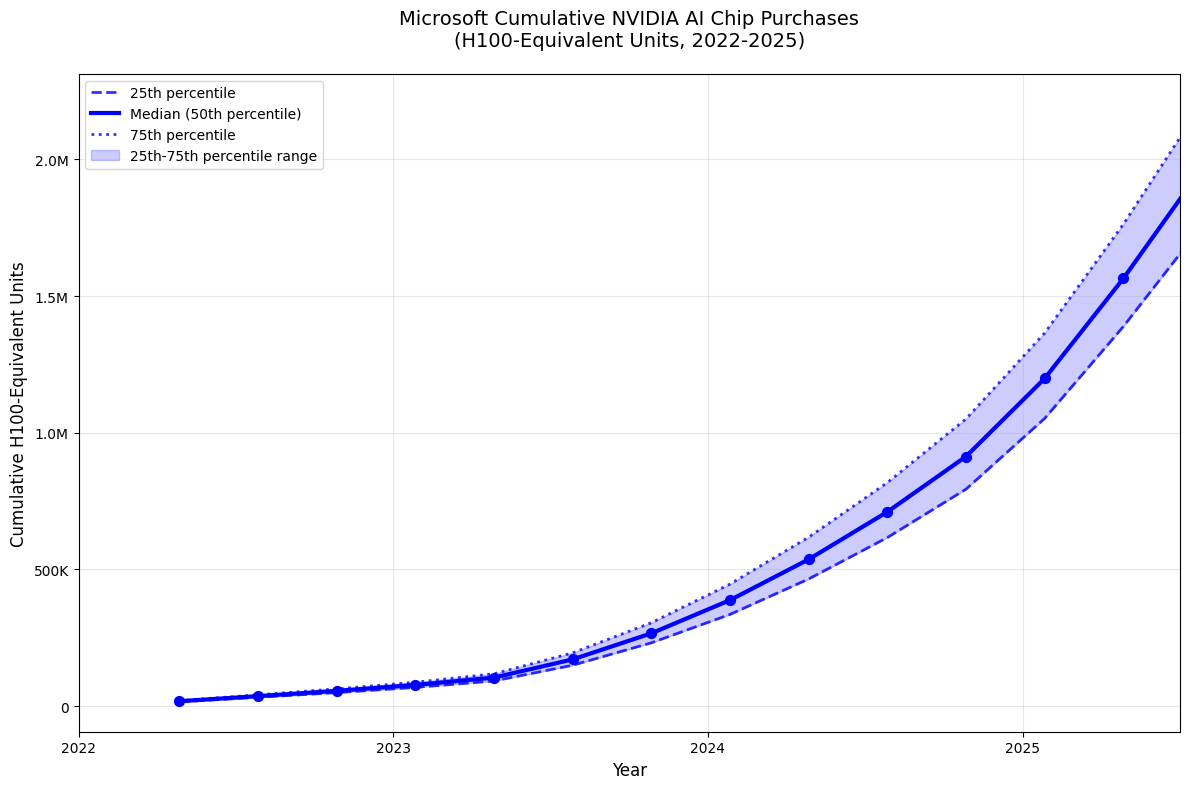

Microsoft Cumulative Purchase Timeline:
FY23Q1 (2022.32): 18,201 H100-equivs (range: 16,038 - 20,633)
FY23Q2 (2022.57): 36,810 H100-equivs (range: 32,421 - 41,681)
FY23Q3 (2022.82): 56,141 H100-equivs (range: 49,640 - 63,352)
FY23Q4 (2023.07): 77,638 H100-equivs (range: 68,716 - 87,643)
FY24Q1 (2023.32): 104,628 H100-equivs (range: 92,266 - 118,473)
FY24Q2 (2023.57): 171,179 H100-equivs (range: 149,865 - 195,148)
FY24Q3 (2023.82): 266,500 H100-equivs (range: 231,819 - 305,186)
FY24Q4 (2024.07): 387,886 H100-equivs (range: 335,771 - 446,617)
FY25Q1 (2024.32): 537,005 H100-equivs (range: 465,398 - 618,200)
FY25Q2 (2024.57): 710,660 H100-equivs (range: 616,893 - 817,757)
FY25Q3 (2024.82): 913,272 H100-equivs (range: 793,821 - 1,050,805)
FY25Q4 (2025.07): 1,198,746 H100-equivs (range: 1,052,662 - 1,364,953)
FY26Q1 (2025.32): 1,564,456 H100-equivs (range: 1,388,683 - 1,762,952)
FY26Q2 (2025.57): 1,967,787 H100-equivs (range: 1,757,837 - 2,203,701)


In [21]:
# Microsoft Cumulative Time Series Chart
# ======================================

# Calculate cumulative sums for each percentile
microsoft_quarterly_clean_sorted = microsoft_quarterly_clean.sort_values('decimal_year')

# Calculate cumulative sums
microsoft_quarterly_clean_sorted['cumulative_25th'] = microsoft_quarterly_clean_sorted['h100_equivs_25th'].cumsum()
microsoft_quarterly_clean_sorted['cumulative_median'] = microsoft_quarterly_clean_sorted['h100_equivs_median'].cumsum()
microsoft_quarterly_clean_sorted['cumulative_75th'] = microsoft_quarterly_clean_sorted['h100_equivs_75th'].cumsum()

# Create the time series chart
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the three percentile lines
ax.plot(microsoft_quarterly_clean_sorted['decimal_year'],
        microsoft_quarterly_clean_sorted['cumulative_25th'],
        'b--', linewidth=2, label='25th percentile', alpha=0.8)

ax.plot(microsoft_quarterly_clean_sorted['decimal_year'],
        microsoft_quarterly_clean_sorted['cumulative_median'],
        'b-', linewidth=3, label='Median (50th percentile)')

ax.plot(microsoft_quarterly_clean_sorted['decimal_year'],
        microsoft_quarterly_clean_sorted['cumulative_75th'],
        'b:', linewidth=2, label='75th percentile', alpha=0.8)

# Fill between 25th and 75th percentiles for uncertainty band
ax.fill_between(microsoft_quarterly_clean_sorted['decimal_year'],
                microsoft_quarterly_clean_sorted['cumulative_25th'],
                microsoft_quarterly_clean_sorted['cumulative_75th'],
                alpha=0.2, color='blue', label='25th-75th percentile range')

# Add markers at quarterly points
ax.scatter(microsoft_quarterly_clean_sorted['decimal_year'],
           microsoft_quarterly_clean_sorted['cumulative_median'],
           s=50, color='blue', zorder=5)

# Formatting
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Cumulative H100-Equivalent Units', fontsize=12)
ax.set_title('Microsoft Cumulative NVIDIA AI Chip Purchases\n(H100-Equivalent Units, 2022-2025)', fontsize=14, pad=20)

# Format y-axis to show values in thousands/millions
def format_thousands(x, p):
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    else:
        return f'{x:.0f}'

ax.yaxis.set_major_formatter(plt.FuncFormatter(format_thousands))

# Set x-axis to show years nicely
ax.set_xlim(2022, 2025.5)
ax.set_xticks([2022, 2023, 2024, 2025])

# Add grid and legend
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', fontsize=10)

# Add some key milestone annotations
final_median = microsoft_quarterly_clean_sorted['cumulative_median'].iloc[-1]
final_year = microsoft_quarterly_clean_sorted['decimal_year'].iloc[-1]
# ax.annotate(f'Total by {final_year:.1f}: {final_median:,.0f}',
#             xy=(final_year, final_median),
#             xytext=(final_year-0.5, final_median*0.8),
#             arrowprops=dict(arrowstyle='->', color='black', alpha=0.7),
#             fontsize=10, ha='center')

plt.tight_layout()
plt.show()

print("Microsoft Cumulative Purchase Timeline:")
print("=" * 40)
for _, row in microsoft_quarterly_clean_sorted.iterrows():
    quarter = row.name
    year = row['decimal_year']
    cumulative_25th = row['cumulative_25th']
    cumulative_median = row['cumulative_median']
    cumulative_75th = row['cumulative_75th']
    print(f"{quarter} ({year:.2f}): {cumulative_median:,.0f} H100-equivs (range: {cumulative_25th:,.0f} - {cumulative_75th:,.0f})")

In [22]:
microsoft_quarterly_clean_sorted.to_csv('microsoft_cumulative.csv')

## CoreWeave, Oracle, and xAI


### CoreWeave

In [23]:
H100_share_2024 = (0.6, 0.8)
GPU_count_2024 = 250000



COREWEAVE_DATA = {
    # GPU counts from S-1 filing
    'gpus_2024_end': 250_000,

    # GPU mix estimates for installed base at end of 2024
    'hopper_share_2024': (0.6, 0.8),  # 60-80% H100s, rest A100s

    # parameters for estimating data center power of GPUs beyond the 2024 installed base (including hypothetical capacity for GPUs waiting to be installed)
    # 55 MW installed in Q1 and Q2 2025 on average, 72 MW installed per quarter in 2024
    # and CoreWeave's capex is generally ramping up
    'gpu_power_per_quarter': (50, 100),
    # hard variable to name: this represents the number of "quarters' worth" of GPUs CoreWeave has purchased beyond the 2024 installed base.
    # which incorporates uncertainty over the time delay between taking delivery of GPUs and installation in a data center
    'quarters_backlog': (2, 4),

    'h100_datacenter_power_w': (1400, 1700),    # H100 power capacity with PUE overhead
    'NVL72_power_w': (120000, 132000),  # server power rating for NVL72 (72 B200s)
    'NVL72_overhead_factor': (1.1, 1.7),   # PUE overhead (SemiAnalysis estimates 1.35x)
    # the lower end of this range is based on the three Nvidia quarters ending April 2025. The upper is shifted by one quarter
    # REVISIT AFTER NVDA EARNINGS
    'blackwell_share': (0.33, 0.6)
}

n_samples = 10000

# Installed base at end of 2024: 250k GPUs
installed_base = COREWEAVE_DATA['gpus_2024_end']

# Mix of installed base (Hopper vs older generation)
hopper_share_installed = sq_distribution(*COREWEAVE_DATA['hopper_share_2024'], rclip = 1)

# Installed base H100-equivalents
hopper_count = installed_base * hopper_share_installed
a100_count = installed_base * (1 - hopper_share_installed)

# Convert A100s to H100-equivalents (A100 is 312 TFLOPS vs H100's 989 TFLOPS)
a100_h100_equiv = a100_count * (CHIP_SPECS['A100'] / CHIP_SPECS['H100'])
installed_base_h100_equiv = hopper_count + a100_h100_equiv

samples = installed_base_h100_equiv @ n_samples

print_percentile_results(samples, "CoreWeave H100-equivs at end of 2024")

gpu_power_per_quarter = sq_distribution(*COREWEAVE_DATA['gpu_power_per_quarter']) * 1e6
quarters_backlog = sq_distribution(*COREWEAVE_DATA['quarters_backlog'])

new_gpu_power_2025 = gpu_power_per_quarter * quarters_backlog

blackwell_share = sq_distribution(*COREWEAVE_DATA['blackwell_share'], lclip = 0, rclip = 1)

h100_dc_power_w = sq_distribution(*COREWEAVE_DATA['h100_datacenter_power_w'])
NVL72_power_w = sq_distribution(*COREWEAVE_DATA['NVL72_power_w'])
NVL72_overhead_factor = sq_distribution(*COREWEAVE_DATA['NVL72_overhead_factor'])

gb200_dc_power_w = NVL72_power_w * NVL72_overhead_factor / 72
gb200_power_samples = gb200_dc_power_w @ n_samples
print_percentile_results(gb200_power_samples, "GB200 power capacity in a data center (W)")

# Estimate power and GPU count by model. Assumes all non-Blackwell chips in 2025 are H100
blackwell_power_w = new_gpu_power_2025 * blackwell_share
h100_power_w = new_gpu_power_2025 * (1 - blackwell_share)
cw_blackwell_2025 = blackwell_power_w / gb200_dc_power_w
cw_hopper_2025 = h100_power_w / h100_dc_power_w

blackwell_h100_equiv = cw_blackwell_2025 * (CHIP_SPECS['B200'] / CHIP_SPECS['H100'])
total_coreweave_h100_equiv = installed_base_h100_equiv + cw_hopper_2025 + blackwell_h100_equiv


coreweave_samples = total_coreweave_h100_equiv @ n_samples
print_percentile_results(coreweave_samples, "Total CoreWeave H100-equivs as of July 2025")

CoreWeave H100-equivs at end of 2024:
  25: 183,681
  50: 197,102
  75: 211,101
GB200 power capacity in a data center (W):
  25: 2,131
  50: 2,389
  75: 2,689
Total CoreWeave H100-equivs as of July 2025:
  25: 324,870
  50: 360,118
  75: 404,108


{25: 324870, 50: 360118, 75: 404108}

# Integrating CoreWeave and H20 with "Other" bar

In [24]:
other_samples

print_percentile_results(other_samples, "Non-Big 4 hyperscalers")

other_minus_coreweave = other_samples - coreweave_samples

print_percentile_results(other_minus_coreweave, "Non-Big 4 hyperscalers, non-CoreWeave")

Non-Big 4 hyperscalers:
  25: 4,477,083
  50: 4,951,101
  75: 5,429,999
Non-Big 4 hyperscalers, non-CoreWeave:
  25: 4,103,302
  50: 4,583,626
  75: 5,065,878


{25: 4103302, 50: 4583626, 75: 5065878}

In [25]:
# Shuffle to decorrelate (approximate independence)
np.random.shuffle(other_samples)
np.random.shuffle(coreweave_samples)
other_minus_coreweave_shuffled = other_samples - coreweave_samples

# essentially no difference
print_percentile_results(other_minus_coreweave_shuffled, "Non-Big 4 hyperscalers, non-CoreWeave")

Non-Big 4 hyperscalers, non-CoreWeave:
  25: 4,108,201
  50: 4,584,225
  75: 5,062,101


{25: 4108201, 50: 4584225, 75: 5062101}

In [26]:
company_results

{'Microsoft': {25: 2037942, 50: 2228484, 75: 2431468},
 'Meta': {25: 961617, 50: 1132396, 75: 1334474},
 'Alphabet': {25: 694553, 50: 836528, 75: 1007981},
 'Amazon': {25: 698236, 50: 838027, 75: 1006826},
 'Other': {25: 4477083, 50: 4951101, 75: 5429999}}

In [27]:
company_results['CoreWeave'] = print_percentile_results(coreweave_samples, "CoreWeave H100-Equivalents")
company_results['Other'] = print_percentile_results(other_minus_coreweave, f"{company} H100-Equivalents")

CoreWeave H100-Equivalents:
  25: 324,870
  50: 360,118
  75: 404,108
Amazon H100-Equivalents:
  25: 4,103,302
  50: 4,583,626
  75: 5,065,878


In [28]:
other_minus_h20 = other_minus_coreweave - h20_h100_samples
company_results['Other'] = print_percentile_results(other_minus_h20)
company_results['H20'] = print_percentile_results(h20_h100_samples)


Percentiles:
  25: 3,863,178
  50: 4,342,531
  75: 4,825,060
Percentiles:
  25: 231,005
  50: 239,270
  75: 248,016


# TPU estimates

In [29]:
# Google TPU Analysis
# ===================

# Core chip performance specifications (TFLOPS for ML workloads)
CHIP_SPECS = {
    'A100': 312,      # NVIDIA A100
    'H100': 989,      # NVIDIA H100 (baseline for equivalence)
    'H20': 148,       # Export-restricted chip for China
    'B200': 2250,     # Blackwell B200/GB200
    'TPUv3': 123,     # Google TPU v3
    'TPUv4': 275,     # Google TPU v4
    'TPUv4i': 138,    # Google TPU v4i (inference optimized)
    'TPUv5e': 197,    # Google TPU v5e
    'TPUv5p': 459,    # Google TPU v5p, used to train Gemini 2.5
    'TPUv6e': 918
    #TPUv6p does not exist, v6e is the only v6 variant to be announced
    #TPUv7 (Ironwood) was announced recently and most likely not deployed at scale yet
}

# TPU deployment estimates from TechInsights and public hints
TPU_ESTIMATES = {
    # TechInsights report: 1.5M TPUs in 2022 ±20% uncertainty
    'tpu_count_2022': 1_500_000,
    'techinsights_uncertainty': 1.2,

    # Estimated production for subsequent years
    'tpu_count_2023': 2_000_000,
    'tpu_count_2024_h1': (1_000_000, 1_500_000),  # H1 2024 production
    #'tpu_count_2024': (2_000_000, 3_000_000),  # Extrapolated 2024 production
    #'tpu_count_2025_q1': (500_000, 1_000_000),  # Extrapolated 2025 production

    # Mix estimates for deployed TPU generations
    'v3_proportion_2022': (0.2, 0.6),      # 20-60% v3, rest v4
    'v4i_proportion_of_v4': (0.1, 0.9),    # 10-90% of v4s are v4i
    'v4_proportion_2023': (0.5, 0.8),      # 50-80% v4, rest v5
    'v5_proportion_2024': (1, 1),          # assume Google switched over to v5 by 2024
    'v5e_proportion_of_v5': (0.5, 0.9),    # 50-90% of v5s are v5e

    # Power-based estimate (Google's >1GW AI infrastructure)
    'google_capacity_mw': (1000, 2000),    # 1-2 GW installed
    'google_pue': 1.1,                     # Power Usage Effectiveness
    'tpuv4_power_watts': 275,             # TPUv4 power consumption
    'server_to_chip_power_ratio': 1.96,    # Based on H100 server ratios
}

def estimate_tpu_h100_equivalents_by_year():
    """Estimate TPU deployments converted to H100-equivalents for each year."""

    # 2022 TPUs (based on TechInsights report)
    tpu_count_22 = generate_lognormal_from_percentiles(
        TPU_ESTIMATES['tpu_count_2022'] / TPU_ESTIMATES['techinsights_uncertainty'],
        TPU_ESTIMATES['tpu_count_2022'] * TPU_ESTIMATES['techinsights_uncertainty'],
        20, 80
    )

    # Mix of TPU generations in 2022
    v3_prop_22 = np.clip(generate_lognormal_from_percentiles(*TPU_ESTIMATES['v3_proportion_2022'], 20, 80), 0, 1)
    v4i_prop = np.clip(generate_lognormal_from_percentiles(*TPU_ESTIMATES['v4i_proportion_of_v4'], 10, 90), 0, 1)

    # Average TFLOPS for 2022 TPUs
    tflops_22 = (v3_prop_22 * CHIP_SPECS['TPUv3'] +
                 (1 - v3_prop_22) * v4i_prop * CHIP_SPECS['TPUv4i'] +
                 (1 - v3_prop_22) * (1 - v4i_prop) * CHIP_SPECS['TPUv4'])

    # Shuffle to decorrelate (approximate independence)
    np.random.shuffle(tflops_22)
    np.random.shuffle(tpu_count_22)

    h100_equiv_22 = (tflops_22 * tpu_count_22) / CHIP_SPECS['H100']

    # 2023 TPUs
    tpu_count_23 = generate_lognormal_from_percentiles(
        TPU_ESTIMATES['tpu_count_2023'] / TPU_ESTIMATES['techinsights_uncertainty'],
        TPU_ESTIMATES['tpu_count_2023'] * TPU_ESTIMATES['techinsights_uncertainty'],
        20, 80
    )

    v4_prop_23 = np.clip(generate_lognormal_from_percentiles(*TPU_ESTIMATES['v4_proportion_2023'], 20, 80), 0, 1)
    v5e_prop = np.clip(generate_lognormal_from_percentiles(*TPU_ESTIMATES['v5e_proportion_of_v5'], 20, 80), 0, 1)

    tflops_23 = (v4_prop_23 * v4i_prop * CHIP_SPECS['TPUv4i'] +
                 v4_prop_23 * (1 - v4i_prop) * CHIP_SPECS['TPUv4'] +
                 (1 - v4_prop_23) * v5e_prop * CHIP_SPECS['TPUv5e'] +
                 (1 - v4_prop_23) * (1 - v5e_prop) * CHIP_SPECS['TPUv5p'])

    np.random.shuffle(tflops_23)
    np.random.shuffle(tpu_count_23)

    h100_equiv_23 = (tflops_23 * tpu_count_23) / CHIP_SPECS['H100']

    # 2024 TPUs (H1 only)
    tpu_count_24 = generate_lognormal_from_percentiles(*TPU_ESTIMATES['tpu_count_2024_h1'], 20, 80)
    tflops_24 = v5e_prop * CHIP_SPECS['TPUv5e'] + (1 - v5e_prop) * CHIP_SPECS['TPUv5p']

    np.random.shuffle(tflops_24)
    np.random.shuffle(tpu_count_24)

    h100_equiv_24 = (tflops_24 * tpu_count_24) / CHIP_SPECS['H100']

    return h100_equiv_22, h100_equiv_23, h100_equiv_24

def estimate_tpu_from_power():
    """Alternative TPU estimate based on Google's disclosed power capacity."""
    capacity_mw = generate_lognormal_from_percentiles(*TPU_ESTIMATES['google_capacity_mw'], 10, 90)

    # Convert power to TPU count
    total_power_per_tpu = (TPU_ESTIMATES['tpuv4_power_watts'] *
                          TPU_ESTIMATES['google_pue'] *
                          TPU_ESTIMATES['server_to_chip_power_ratio'])

    tpu_count = capacity_mw * 1e6 / total_power_per_tpu

    # Convert to H100-equivalents using TPUv4 performance
    h100_equiv = tpu_count * CHIP_SPECS['TPUv4'] / CHIP_SPECS['H100']

    return h100_equiv

# Run TPU analyses
print("TPU Analysis Results:")
print("=" * 40)

h100_equiv_22, h100_equiv_23, h100_equiv_24 = estimate_tpu_h100_equivalents_by_year()

print_percentile_results(h100_equiv_22, "2022 TPUs (H100-equivalents)")
print_percentile_results(h100_equiv_23, "2023 TPUs (H100-equivalents)")
print_percentile_results(h100_equiv_24, "2024 TPUs (H100-equivalents)")

# Total from production-based estimate
total_production_tpus = h100_equiv_22 + h100_equiv_23 + h100_equiv_24
print_percentile_results(total_production_tpus, "Total TPUs from Production Estimate")

# Power-based estimate
power_tpus = estimate_tpu_from_power()
print_percentile_results(power_tpus, "TPUs from Power-Based Estimate")

# Combine both estimates
combined_tpu_samples = np.concatenate([total_production_tpus, power_tpus])
tpu_results = print_percentile_results(combined_tpu_samples, "Combined TPU Estimate (H100-equivalents)")

TPU Analysis Results:
2022 TPUs (H100-equivalents):
  25: 220,378
  50: 271,228
  75: 330,003
2023 TPUs (H100-equivalents):
  25: 406,581
  50: 487,684
  75: 578,780
2024 TPUs (H100-equivalents):
  25: 274,268
  50: 341,298
  75: 418,711
Total TPUs from Production Estimate:
  25: 1,005,928
  50: 1,124,247
  75: 1,255,012
TPUs from Power-Based Estimate:
  25: 552,240
  50: 661,488
  75: 790,980
Combined TPU Estimate (H100-equivalents):
  25: 660,926
  50: 914,727
  75: 1,134,695


In [30]:
# sensitivity analysis on TPU chip-based estimate

# # TPU deployment estimates from TechInsights and public hints
# TPU_ESTIMATES = {
#     # TechInsights report: 1.5M TPUs in 2022 ±20% uncertainty
#     'tpu_count_2022': 1_500_000,
#     'techinsights_uncertainty': 1.2,

#     # Estimated production for subsequent years
#     'tpu_count_2023': 2_000_000,
#     'tpu_count_2024_h1': (1_000_000, 1_500_000),  # H1 2024 production
#     #'tpu_count_2024': (2_000_000, 3_000_000),  # Extrapolated 2024 production
#     #'tpu_count_2025_q1': (500_000, 1_000_000),  # Extrapolated 2025 production

#     # Mix estimates for deployed TPU generations
#     'v3_proportion_2022': (0.2, 0.6),      # 20-60% v3, rest v4
#     'v4i_proportion_of_v4': (0.5, 0.9),    # 10-90% of v4s are v4i
#     'v4_proportion_2023': (0.5, 0.8),      # 50-80% v4, rest v5
#     'v5_proportion_2024': (1, 1),          # assume Google switched over to v5 by 2024
#     'v5e_proportion_of_v5': (0.5, 0.9),    # 50-90% of v5s are v5e

#     # Power-based estimate (Google's >1GW AI infrastructure)
#     'google_capacity_mw': (1000, 2000),    # 1-2 GW installed
#     'google_pue': 1.1,                     # Power Usage Effectiveness
#     'tpuv4_power_watts': 275,             # TPUv4 power consumption
#     'server_to_chip_power_ratio': 1.96,    # Based on H100 server ratios
# }


# increase v3 share in 2022 from 20-60% to 50-90%
TPU_ESTIMATES['v3_proportion_2022'] = (0.5, 0.9)
# dramatically increase v4i proportion from 10-90% to 60-90%
TPU_ESTIMATES['v4i_proportion_of_v4'] = (0.6, 0.9)
# cut 2024 estimate in half
TPU_ESTIMATES['tpu_count_2024_h1'] = (500_000, 700_000)

h100_equiv_22, h100_equiv_23, h100_equiv_24 = estimate_tpu_h100_equivalents_by_year()

print_percentile_results(h100_equiv_22, "2022 TPUs (H100-equivalents)")
print_percentile_results(h100_equiv_23, "2023 TPUs (H100-equivalents)")
print_percentile_results(h100_equiv_24, "2024 TPUs (H100-equivalents)")

total_production_tpus = h100_equiv_22 + h100_equiv_23 + h100_equiv_24
print_percentile_results(total_production_tpus, "Total TPUs from Production Estimate")

# overall, median estimate goes down from 1.1M to 800k. So it's not that sensitive to our assumptions
# didn't change the assumption about v5 being 100% of 2024 though

2022 TPUs (H100-equivalents):
  25: 178,782
  50: 208,850
  75: 244,324
2023 TPUs (H100-equivalents):
  25: 350,184
  50: 416,371
  75: 497,342
2024 TPUs (H100-equivalents):
  25: 135,262
  50: 164,519
  75: 198,396
Total TPUs from Production Estimate:
  25: 722,463
  50: 804,310
  75: 898,046


{25: 722463, 50: 804310, 75: 898046}

In [31]:
# Combined Results and Analysis
# =============================

# Calculate Alphabet's total (NVIDIA + TPU)
alphabet_nvidia_samples = company_samples['Alphabet']
alphabet_tpu_samples = np.random.choice(combined_tpu_samples, len(alphabet_nvidia_samples))
alphabet_total_samples = alphabet_nvidia_samples + alphabet_tpu_samples

print("Final Results Summary:")
print("=" * 50)

print("\nNVIDIA H100-Equivalent Sales by Company:")
for company in ['Microsoft', 'Meta', 'Alphabet', 'Amazon', 'Other']:
    results = company_results[company]
    print(f"  {company}: {results[25]:,} - {results[75]:,} (median: {results[50]:,})")

print(f"\nGoogle TPUs (H100-equivalents): {tpu_results[25]:,} - {tpu_results[75]:,} (median: {tpu_results[50]:,})")

alphabet_total_results = print_percentile_results(alphabet_total_samples, "Alphabet Total (NVIDIA + TPUs)")

# Calculate market share of "Other" companies
other_fraction_samples = company_samples['Other'] / (total_samples + np.random.choice(combined_tpu_samples, len(total_samples)))
other_fraction_results = sq.get_percentiles(other_fraction_samples, percentiles=[25, 50, 75])

print(f"\n'Other' companies represent {other_fraction_results[25]:.1%} - {other_fraction_results[75]:.1%} of total market")
print(f"(median: {other_fraction_results[50]:.1%})")

Final Results Summary:

NVIDIA H100-Equivalent Sales by Company:
  Microsoft: 2,037,942 - 2,431,468 (median: 2,228,484)
  Meta: 961,617 - 1,334,474 (median: 1,132,396)
  Alphabet: 694,553 - 1,007,981 (median: 836,528)
  Amazon: 698,236 - 1,006,826 (median: 838,027)
  Other: 3,863,178 - 4,825,060 (median: 4,342,531)

Google TPUs (H100-equivalents): 660,926 - 1,134,695 (median: 914,727)
Alphabet Total (NVIDIA + TPUs):
  25: 1,508,089
  50: 1,780,791
  75: 2,037,495

'Other' companies represent 40.6% - 49.6% of total market
(median: 45.1%)


# Visualizations

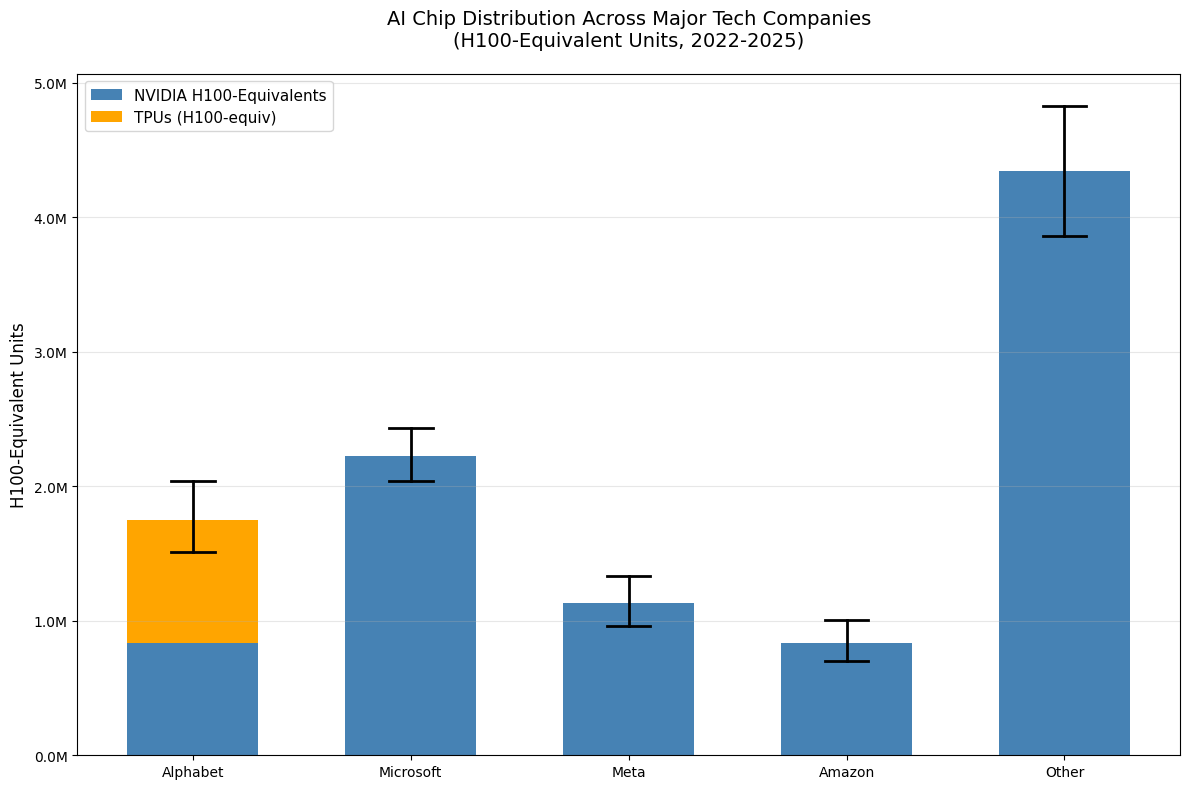


Visualization Notes:
- Error bars show 25th-75th percentile range
- Alphabet includes both NVIDIA chips and TPUs
- All values converted to H100-equivalent compute units
- Based on NVIDIA revenue FY2023-FY2025 and industry estimates


In [32]:
# Visualization
# =============

# Prepare data for plotting
companies = ['Alphabet', 'Microsoft', 'Meta', 'Amazon', 'Other']
nvidia_medians = [company_results[company][50] for company in companies]
nvidia_25th = [company_results[company][25] for company in companies]
nvidia_75th = [company_results[company][75] for company in companies]

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(companies))
width = 0.6

# Create NVIDIA bars
nvidia_bars = ax.bar(x, nvidia_medians, width, label="NVIDIA H100-Equivalents", color='steelblue')

# Add TPU bar for Alphabet (stacked on NVIDIA)
alphabet_idx = companies.index('Alphabet')
tpu_median = tpu_results[50]
ax.bar(alphabet_idx, tpu_median, width, bottom=nvidia_medians[alphabet_idx],
       label="TPUs (H100-equiv)", color='orange')

# Add confidence intervals
for i, company in enumerate(companies):
    if company != 'Alphabet':
        # Regular confidence intervals for NVIDIA-only companies
        bar_width = width / 6
        ax.plot([i - bar_width, i + bar_width], [nvidia_25th[i], nvidia_25th[i]], 'k-', linewidth=2)
        ax.plot([i - bar_width, i + bar_width], [nvidia_75th[i], nvidia_75th[i]], 'k-', linewidth=2)
        ax.plot([i, i], [nvidia_25th[i], nvidia_75th[i]], 'k-', linewidth=2)
    else:
        # Confidence interval for Alphabet total (NVIDIA + TPU)
        total_25th = alphabet_total_results[25]
        total_75th = alphabet_total_results[75]
        bar_width = width / 6
        ax.plot([i - bar_width, i + bar_width], [total_25th, total_25th], 'k-', linewidth=2)
        ax.plot([i - bar_width, i + bar_width], [total_75th, total_75th], 'k-', linewidth=2)
        ax.plot([i, i], [total_25th, total_75th], 'k-', linewidth=2)

# Formatting
ax.set_ylabel('H100-Equivalent Units', fontsize=12)
ax.set_title('AI Chip Distribution Across Major Tech Companies\n(H100-Equivalent Units, 2022-2025)', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(companies)
ax.legend(fontsize=11)

# Format y-axis to show values in millions
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Add grid for readability
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nVisualization Notes:")
print("- Error bars show 25th-75th percentile range")
print("- Alphabet includes both NVIDIA chips and TPUs")
print("- All values converted to H100-equivalent compute units")
print("- Based on NVIDIA revenue FY2023-FY2025 and industry estimates")

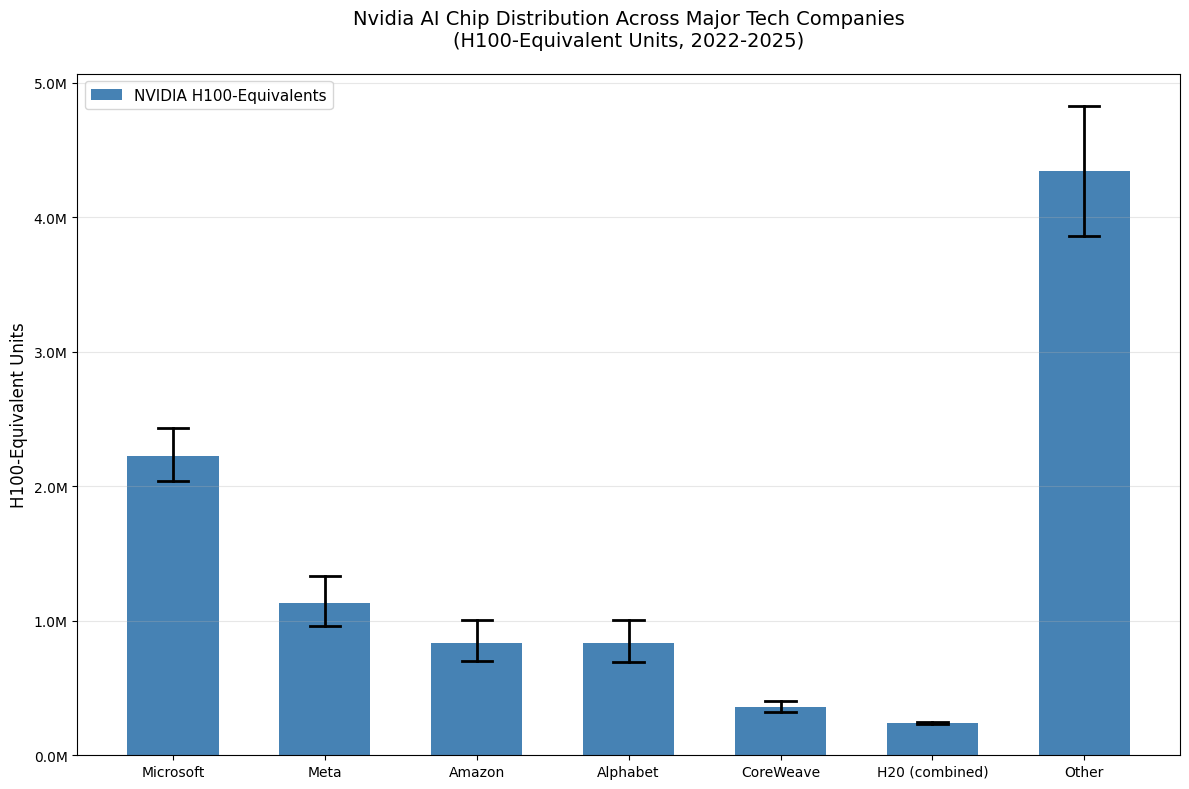


Visualization Notes:
- Error bars show 25th-75th percentile range
- Alphabet includes both NVIDIA chips and TPUs
- All values converted to H100-equivalent compute units
- Based on NVIDIA revenue FY2023-FY2025 and industry estimates


In [33]:
# version without TPU

# Visualization
# =============

# Prepare data for plotting
companies = [ 'Microsoft', 'Meta', 'Amazon', 'Alphabet',  'CoreWeave', 'H20', 'Other']
nvidia_medians = [company_results[company][50] for company in companies]
nvidia_25th = [company_results[company][25] for company in companies]
nvidia_75th = [company_results[company][75] for company in companies]

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(companies))
width = 0.6

# Create NVIDIA bars
nvidia_bars = ax.bar(x, nvidia_medians, width, label="NVIDIA H100-Equivalents", color='steelblue')

# Add TPU bar for Alphabet (stacked on NVIDIA)
# alphabet_idx = companies.index('Alphabet')
# tpu_median = tpu_results[50]
# ax.bar(alphabet_idx, tpu_median, width, bottom=nvidia_medians[alphabet_idx],
#        label="TPUs (H100-equiv)", color='orange')

# Add confidence intervals
for i, company in enumerate(companies):
    bar_width = width / 6
    ax.plot([i - bar_width, i + bar_width], [nvidia_25th[i], nvidia_25th[i]], 'k-', linewidth=2)
    ax.plot([i - bar_width, i + bar_width], [nvidia_75th[i], nvidia_75th[i]], 'k-', linewidth=2)
    ax.plot([i, i], [nvidia_25th[i], nvidia_75th[i]], 'k-', linewidth=2)


# Formatting
ax.set_ylabel('H100-Equivalent Units', fontsize=12)
ax.set_title('Nvidia AI Chip Distribution Across Major Tech Companies\n(H100-Equivalent Units, 2022-2025)', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels([ 'Microsoft', 'Meta', 'Amazon', 'Alphabet',  'CoreWeave', 'H20 (combined)', 'Other'])
ax.legend(fontsize=11)

# Format y-axis to show values in millions
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Add grid for readability
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nVisualization Notes:")
print("- Error bars show 25th-75th percentile range")
print("- Alphabet includes both NVIDIA chips and TPUs")
print("- All values converted to H100-equivalent compute units")
print("- Based on NVIDIA revenue FY2023-FY2025 and industry estimates")